# Long Short-Term Memory Network

https://github.com/keras-team/keras/tree/master/examples

https://github.com/2wavetech/Time-Series-Analysis-and-Prediction

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

The Long Short-Term Memory network is a recurrent neural network that is trained using Backpropagation Through Time and overcomes the vanishing gradient problem. Instead of neurons, LSTM networks have memory blocks that are connected through layers. There are three types of gates within a unit:

__Forget Gate:__ conditionally decides what information to throw away from the block.

__Input Gate:__ conditionally decides which values from the input to update the memory state.

__Output Gate:__ conditionally decides what to output based on input and the memory of the block.

LSTM works better if we are dealing with huge amount of data and enough training data is available, while ARIMA is better for smaller datasets. ARIMA models are linear and LSTM models are nonlinear. Some other parametric nonlinear time series models that statisticians have studied are Threshold Autoregressive Models (TAR) and Smooth Transition Autoregressive Models (STAR).

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

This is a univariate time series problem.

In [5]:
data = pd.read_csv(r'C:\Users\Sabeeha\Desktop\project\airline_passanger\air.csv',
                   skipfooter=5, index_col='Month', parse_dates=['Month'])
data.head()

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [6]:
data.shape

(139, 1)

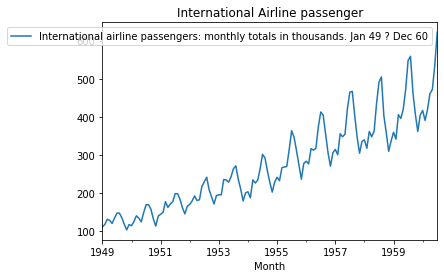

In [22]:
data.plot(title='International Airline passenger')

In [4]:
def ts(df, lag=1):
    cols = [df.shift(i) for i in range(1, lag+1)]
    cols.append(df)      # append the original as the output y onto the last column
    df = pd.concat(cols, axis=1)
    df.fillna(0, inplace=True)   # turn NaN to 0
    return df

In [5]:
#ts(data['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], lag=5)

In [10]:
# Reshape your data using array.reshape(-1, 1) if your data has a single feature
dataset = data['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'].values
dataset = dataset.reshape(-1,1)
dataset = dataset.astype("float32")
dataset.shape

(139, 1)

In [11]:
# scaling 
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [12]:
# train, test split
train_size = int(len(dataset) * 0.50)
test_size = len(dataset) - train_size
train = dataset[0:train_size,:]
test = dataset[train_size:len(dataset),:]
print("train size: {}, test size: {} ".format(len(train), len(test)))

train size: 69, test size: 70 


In [13]:
time_stemp = 3
dataX,dataY = [],[]

for i in range(len(train)-time_stemp-1):
    a = train[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(train[i + time_stemp, 0])

trainX = np.array(dataX)
trainY = np.array(dataY)  

In [14]:
dataX,dataY = [],[]

for i in range(len(test)-time_stemp-1):
    a = test[i:(i+time_stemp), 0]
    dataX.append(a)
    dataY.append(test[i + time_stemp, 0])

testX = np.array(dataX)
testY = np.array(dataY)  

In [15]:
# LSTM requires a three-dimensional input. The shape of it is (batch_size, input_length, dimension).
# reshape input to be [samples, time_steps, features]

trainX = trainX.reshape(trainX.shape[0], 1, trainX.shape[1])
testX = testX.reshape(testX.shape[0], 1, testX.shape[1])
trainX.shape, testX.shape

((65, 1, 3), (66, 1, 3))

## LSTM Inputs

LSTM Input Shape: 3D tensor with shape (batch_size, timesteps, input_dim)

```python
model.add(LSTM(hidden_nodes, input_shape=(timesteps, input_dim)))
#or
model.add(LSTM(8, batch_input_shape = (batch_size, timesteps, input_dim,stateful=True)
```
__timesteps (or window)__ = the number of timesteps you want to consider. E.g. if you want to classify a sentence, this would be the number of words in a sentence.

__input_dim__ = the dimensions of your features/embeddings. E.g. a vector representation of the words in the sentence


The LSTM network expects the input data (X) to be provided with a specific array structure in the form of 3D: [samples, time steps, features], or in other words, 3D tensor with shape (batch_size, timesteps, input_dim), or optionally, 2D tensors with shape (batch_size, output_dim).


## What's the difference between input_shape and batch_input_shape in LSTM

LSTM, like all layers in Keras, accepts two arguments: input_shape and batch_input_shape. The difference is in convention that input_shape does not contain the batch size, while batch_input_shape is the full input shape including the batch size.

But that's not all. LSTM layer is a recurrent layer, hence it expects a 3-dimensional input (batch_size, timesteps, input_dim). That's why the correct specification is input_shape=(20, 1) or batch_input_shape=(10000, 20, 1). Plus, your training array should also be reshaped to denote that it has 20 time steps and 1 input feature per each step.

Hence, the solution:

```python
X_train = np.expand_dims(X_train, 2)  # makes it (10000,20,1)
model = Sequential()
model.add(LSTM(..., input_shape=(20, 1)))
```
## Does batch_size in Keras have any effects in results' quality?

Batch size impacts learning significantly. What happens when you put a batch through your network is that you average the gradients. The concept is that if your batch size is big enough, this will provide a stable enough estimate of what the gradient of the full dataset would be. By taking samples from your dataset, you estimate the gradient while reducing computational cost significantly. The lower you go, the less accurate your esttimate will be, however in some cases these noisy gradients can actually help escape local minima. When it is too low, your network weights can just jump around if your data is noisy and it might be unable to learn or it converges very slowly, thus negatively impacting total computation time.

Another advantage of batching is for GPU computation, GPUs are very good at parallelizing the calculations that happen in neural networks if part of the computation is the same (for example, repeated matrix multiplication over the same weight matrix of your network). This means that a batch size of 16 will take less than twice the amount of a batch size of 8.

In the case that you do need bigger batch sizes but it will not fit on your GPU, you can feed a small batch, save the gradient estimates and feed one or more batches, and then do a weight update. This way you get a more stable gradient because you increased your virtual batch size.

In [16]:
# model : a vanilla or simple LSTM with one layer

batch_size = 1

model = Sequential()
#model.add(LSTM(units=8, input_shape=(1, time_stemp))) # 2D tensors with shape (batch_size, output_dim).
model.add(LSTM(8, batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2]),stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [17]:
model.fit(trainX, trainY, epochs=10, batch_size=1)

Epoch 1/10
65/65 [==============================] - 2s 30ms/step - loss: 0.0119 - accuracy: 0.0154
Epoch 2/10
65/65 [==============================] - 0s 3ms/step - loss: 0.0067 - accuracy: 0.0154
Epoch 3/10
65/65 [==============================] - 0s 3ms/step - loss: 0.0060 - accuracy: 0.0154
Epoch 4/10
65/65 [==============================] - 0s 3ms/step - loss: 0.0056 - accuracy: 0.0154
Epoch 5/10
65/65 [==============================] - 0s 3ms/step - loss: 0.0046 - accuracy: 0.0154
Epoch 6/10
65/65 [==============================] - 0s 3ms/step - loss: 0.0045 - accuracy: 0.0154
Epoch 7/10
65/65 [==============================] - 0s 4ms/step - loss: 0.0040 - accuracy: 0.0154
Epoch 8/10
65/65 [==============================] - 0s 3ms/step - loss: 0.0039 - accuracy: 0.0154
Epoch 9/10
65/65 [==============================] - 0s 3ms/step - loss: 0.0035 - accuracy: 0.0154
Epoch 10/10
65/65 [==============================] - 0s 3ms/step - loss: 0.0040 - accuracy: 0.0154


In [18]:
trainPredict = model.predict(trainX,batch_size = 1)
testPredict = model.predict(testX,batch_size = 1)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 25.83 RMSE
Test Score: 77.62 RMSE


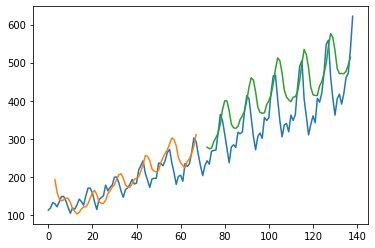

In [16]:
# shifting train
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_stemp:len(trainPredict)+time_stemp, :] = trainPredict

# shifting test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(time_stemp*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Why set return_sequences=True and stateful=True for tf.keras.layers.LSTM?

We feed in a sequence of inputs (x's), one batch at a time and each LSTM cell returns an output (y_i). So if your input is of size batch_size x time_steps X input_size then the LSTM output will be batch_size X time_steps X output_size. This is called a sequence to sequence model because an input sequence is converted into an output sequence. Typical usages of this model are in tagger (POS tagger, NER Tagger). In keras this is achieved by setting return_sequences=True.

stateful=True

From the documentation, "If True, the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch."

In normal (or “stateless”) mode, Keras shuffles the samples, and the dependencies between the time series and the lagged version of itself are lost. However, when run in “stateful” mode, we can often get high accuracy results by leveraging the autocorrelations present in the time series.

In [17]:
import tensorflow as tf
import numpy as np
tf.keras.backend.clear_session()
tf.random.set_seed(42)
X = np.array([[[1,2,3],[4,5,6],[7,8,9]],[[1,2,3],[4,5,6],[0,0,0]]], dtype=np.float32)

model = tf.keras.Sequential([tf.keras.layers.LSTM(4, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform')])
print(tf.keras.backend.get_value(model(X)).shape)

(2, 3, 4)


In [18]:
print(tf.keras.backend.get_value(model(X)))

[[[-0.78032774 -0.06589078  0.42429498 -0.07136772]
  [-0.8983276  -0.16955552  0.47843087 -0.04470691]
  [-0.9548513  -0.41247028  0.42742747 -0.02386559]]

 [[-0.5756962   0.08765698  0.4405183  -0.0970213 ]
  [-0.80077946  0.01759103  0.5067261  -0.05963931]
  [-0.43554977  0.01338535  0.17208892 -0.24627887]]]


In [19]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)
model = tf.keras.Sequential([
tf.keras.layers.LSTM(4, return_sequences=False, stateful=True, recurrent_initializer='glorot_uniform')])
print(tf.keras.backend.get_value(model(X)).shape)

(2, 4)


In [20]:
print(tf.keras.backend.get_value(model(X)))

[[-0.9548513  -0.41247028  0.42742747 -0.02386559]
 [-0.43554977  0.01338535  0.17208892 -0.24627887]]


What is mostly used activation function ?

Relu function is mostly used activation function. It will help us to solve vanishing gradient problem

Can i use Relu activation function in output layer ?

No – it has to use in hidden layers

What is an auto-encoder? Why do we "auto-encode"? Hint: it's really a misnomer.
What is a Boltzmann Machine? Why a Boltzmann Machine?
Why do we use sigmoid for an output function? Why tanh? Why not cosine? Why any function in particular?
Why are CNNs used primarily in imaging and not so much other tasks?
Explain backpropagation. Seriously. To the target audience described above.
Is it OK to connect from a Layer 4 output back to a Layer 2 input?
A data-scientist person recently put up a YouTube video explaining that the essential difference between a Neural Network and a Deep Learning network is that the former is trained from output back to input, while the latter is trained from input toward output. Do you agree? Explain.

Usually the first questions are : what do you know about some “pre-deep learning epoch” algorithms, like SVM, KNN, Kmeans, Random Forest…?

Talking about deep learning, here are the questions I was asked to answer:

Implement dropout during forward and backward pass?
Was not very hard, you just have to consider what’s happening during testing vs training phase. In this question, the interviewer can test your knowledge on dropout, and backprop

Neural network training loss/testing loss stays constant, what do you do?
Open question (ask if there could be an error in your code, going deeper, going simpler…)

Why do RNNs have a tendency to suffer from exploding/vanishing gradient?
And probably you know the next question… How to prevent this? You can talk about LSTM cell which helps the gradient from vanishing, but make sure you know why it does so. I also remember having a nice conversation about gradient clipping, where we wonder whether we should clip the gradient element wise, or clip the norm of the gradient.

Then I had a lot of question about some modern architecture, such as Do you know GAN, VAE, and memory augmented neural network? Can you talk about it?
Of course, let me talk about the beauty of variational auto encoder.

Some maths questions such as: Does using full batch means that the convergence is always better given unlimited power?
After the discussion, I was not sure about the answer so I asked the question on Quora[1]

What is the problem with sigmoid during backpropagation?
Very small, between 0.25 and zero.[2]

Given a black box machine learning algorithm that you can’t modify, how could you improve its error?
Open question, you can transform the input for example.

How to find the best hyper parameters?
Random search, grid search, Bayesian search (and what it is?)

What is transfer learning?
If you don’t know, Google is there for you.
